In [ ]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from fredapi import Fred

In [6]:
df = pd.read_csv('sentiment_dataset.csv', index_col=0, parse_dates=True)
df.index = pd.to_datetime(df.index)

#drop recession column
df = df.drop(columns=['Recession'])

In [10]:
df1 = df.copy()

# ensure stationary
df1.loc[:, 'Inflation'] = df1['Inflation'].diff(3)

#
df1.loc[:, 'Unemployment'] = df1['Unemployment'].diff(6)

#filter to drop nans
df1 = df1.loc['1997-06-01':'2023-01-01']

# Reorder columns
df1 = df1[['Sentiment', 'Consumer Confidence', 'Inflation', 'Industrial Production', 'Unemployment']]

#drop nans
df1 = df1.dropna()

In [14]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df1)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Sentiment ::  115.16    > 60.0627   =>   True
Consumer Confidence ::  73.08     > 40.1749   =>   True
Inflation ::  35.71     > 24.2761   =>   True
Industrial Production ::  12.54     > 12.3212   =>   True
Unemployment ::  0.32      > 4.1296    =>   False


In [15]:
def adf_test(series, signif=0.05):
    """Run ADF test and return key results."""
    result = adfuller(series.dropna(), autolag='AIC')
    test_stat, p_value, n_lags, n_obs = result[:4]
    return {
        'Test Statistic': test_stat,
        'p-value': p_value,
        'Lags Used': n_lags,
        'Number of Observations': n_obs,
        'Stationary': p_value < signif
    }

# Apply the ADF test to each column in the filtered DataFrame
for col in df1.columns:
    result = adf_test(df1[col])
    print(f"{col}: p-value = {result['p-value']:.4f}, Stationary = {result['Stationary']}")

Sentiment: p-value = 0.0000, Stationary = True
Consumer Confidence: p-value = 0.0129, Stationary = True
Inflation: p-value = 0.0012, Stationary = True
Industrial Production: p-value = 0.0024, Stationary = True
Unemployment: p-value = 0.0052, Stationary = True


In [16]:
def autocov(timeserie,T=0):
    N=timeserie.size
    mu=timeserie.mean()
    covCoef=0
    for n in range(0,N-T-1):
        covCoef=covCoef+(timeserie[n]-mu)*(timeserie[n+T]-mu)
    return covCoef/float(np.abs(N))
        

def autocoef(timeserie,T=0):
    return autocov(timeserie,T)/autocov(timeserie)

def correlogram(timeserie,maxT,twoside=False):
    N=timeserie.size
    if twoside:
        corrl=np.zeros(2*maxT+1)
        ix=np.array(range(maxT+1))
        ix=np.concatenate((-np.flip(ix[1:]),ix),axis=0)
    else:
        corrl=np.zeros(maxT+1)  
        ix=np.array(range(maxT+1))
    
    for i in range(maxT+1):
        if twoside:
            corrl[i+maxT]=autocoef(timeserie,i);
            if i>0:
                corrl[maxT-i]=corrl[i+maxT]
        else:
            corrl[i]=autocoef(timeserie,i);
    d = {'ACS':corrl, 'upsig':np.ones(maxT+1)*(1.96/np.sqrt(N)),'dnsig':-np.ones(maxT+1)*(1.96/np.sqrt(N))}
    corrl=pd.DataFrame(data=d,index=ix)
    return corrl

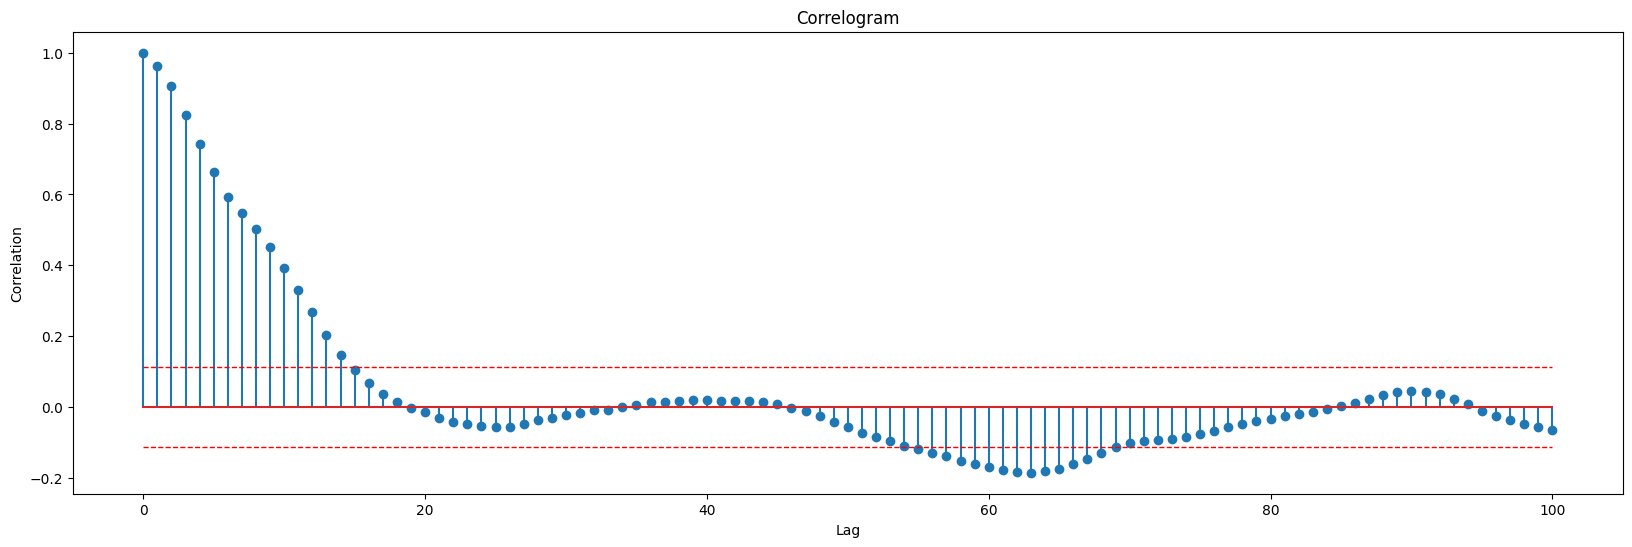

In [17]:
ts = np.asarray(df1["Unemployment"])

N=ts.size
corrl=correlogram(ts,maxT=int(N/3))
corrl.name='Mean Temperature'

plt.figure(figsize=(20, 6))
plt.stem(corrl.index,corrl['ACS'])
plt.plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=1)
plt.plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=1)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Correlogram')

plt.show()

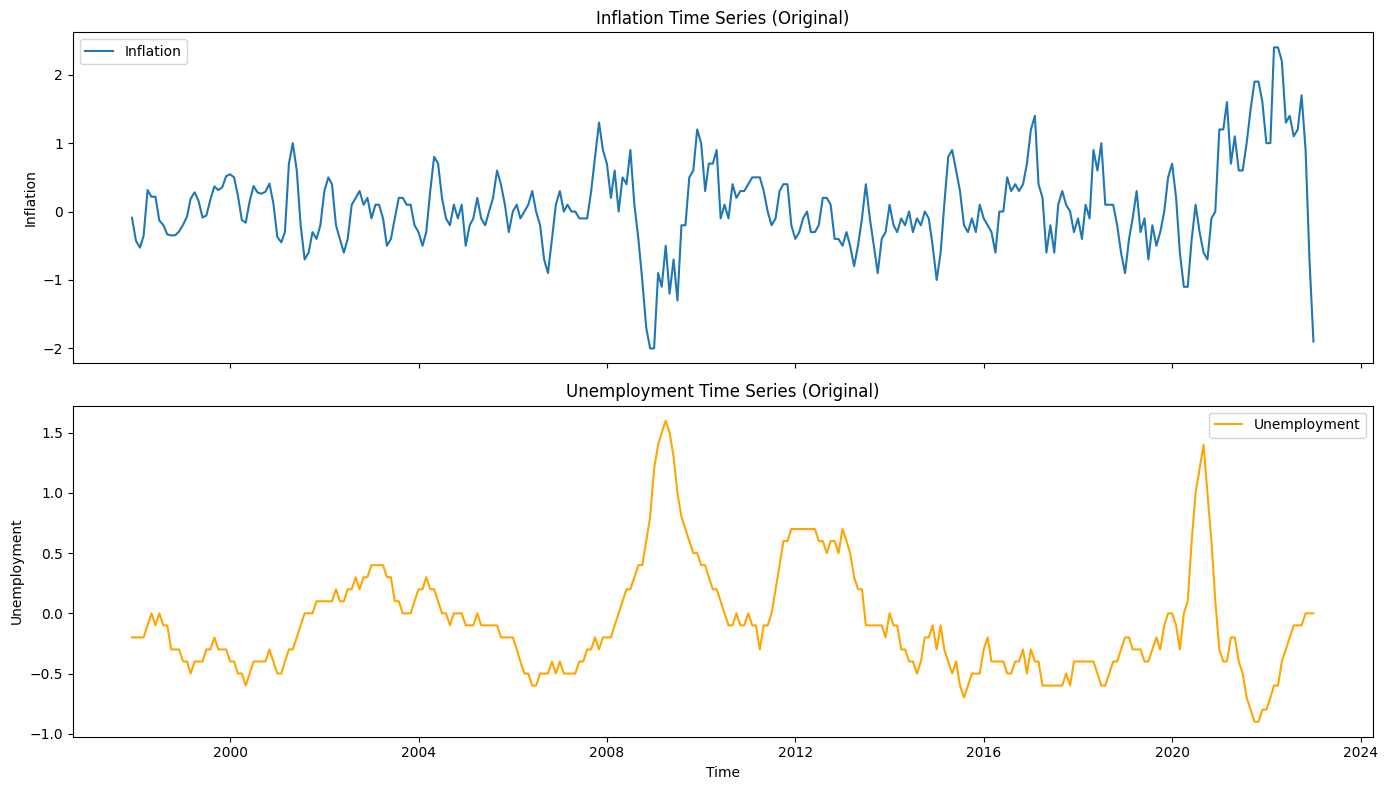

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot Inflation series
axs[0].plot(df1.index, df1['Inflation'], label='Inflation')
axs[0].set_title('Inflation Time Series (Original)')
axs[0].set_ylabel('Inflation')
axs[0].legend()

# Plot Unemployment series
axs[1].plot(df1.index, df1['Unemployment'], label='Unemployment', color='orange')
axs[1].set_title('Unemployment Time Series (Original)')
axs[1].set_ylabel('Unemployment')
axs[1].legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()

In [19]:
# Create a copy of the filtered DataFrame
d = df1.copy()



# Run ADF test on the differenced columns
for col in ['Inflation', 'Unemployment']:
    result = adf_test(d[col])
    print(f"Diff {col}: p-value = {result['p-value']:.4f}, Stationary = {result['Stationary']}")

Diff Inflation: p-value = 0.0012, Stationary = True
Diff Unemployment: p-value = 0.0052, Stationary = True


In [20]:
model = VAR(d)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -8.784577134931258
BIC :  -8.415097706550972
FPE :  0.00015307987302626126
HQIC:  -8.63672740489806 

Lag Order = 2
AIC :  -10.096427123543247
BIC :  -9.417400336522944
FPE :  4.123337033441302e-05
HQIC:  -9.824679623047858 

Lag Order = 3
AIC :  -10.657668611116865
BIC :  -9.667583374089256
FPE :  2.353182113161789e-05
HQIC:  -10.261390889802726 

Lag Order = 4
AIC :  -10.98432808839572
BIC :  -9.681660920331735
FPE :  1.6985371370322434e-05
HQIC:  -10.462882493329461 

Lag Order = 5
AIC :  -11.02755473380105
BIC :  -9.41076962254061
FPE :  1.6284316398203934e-05
HQIC:  -10.38029835093937 

Lag Order = 6
AIC :  -11.04493054295262
BIC :  -9.112478801668063
FPE :  1.602955879071026e-05
HQIC:  -10.271215137777624 

Lag Order = 7
AIC :  -11.31387783157425
BIC :  -9.064197953129614
FPE :  1.2277217532296661e-05
HQIC:  -10.413049788883033 

Lag Order = 8
AIC :  -11.290545461300734
BIC :  -8.72206297046934
FPE :  1.2605238594514926e-05
HQIC:  -10.261945724134742 

Lag Or

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [21]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-0.9075,-0.8442,0.4036,-0.8821
1,-8.664,-8.285,0.0001726,-8.512
2,-9.999,-9.303,4.543e-05,-9.721
3,-10.56,-9.551,2.585e-05,-10.16
4,-10.90,-9.575*,1.840e-05,-10.37*
5,-10.95,-9.310,1.751e-05,-10.30
6,-10.98,-9.014,1.719e-05,-10.19
7,-11.26,-8.980,1.299e-05,-10.35
8,-11.24,-8.644,1.329e-05,-10.20
9,-11.38,-8.465,1.162e-05,-10.21


In [23]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 13, Mar, 2025
Time:                     00:29:14
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -9.68166
Nobs:                     298.000    HQIC:                  -10.4629
Log likelihood:          -372.554    FPE:                1.69854e-05
AIC:                     -10.9843    Det(Omega_mle):     1.20838e-05
--------------------------------------------------------------------
Results for equation Sentiment
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           -2.780917         2.719817           -1.022           0.307
L1.Sentiment                     0.108108         0.059879            1.805           0.071
L1.Consumer 

In [27]:
#Granger Causality Tests
variables = [var for var in model_fitted.names if var != "Sentiment"]
for var in variables:
    causality_result = model_fitted.test_causality("Sentiment", [var], kind='f')

import pandas as pd
gc_results = []
for var in variables:
    result = model_fitted.test_causality("Sentiment", [var], kind='f')
    gc_results.append({
        'Dependent Variable': var,
        'Test Statistic': f"{result.test_statistic:.4f}",
        'p-value': f"{result.pvalue:.4f}", 
        'Significant at 5%': "Yes" if result.pvalue < 0.05 else "No"
    })

gc_df = pd.DataFrame(gc_results)
print("\nGranger Causality Results:\n")
print(gc_df.to_string(index=False))


Granger Causality Results:

   Dependent Variable Test Statistic p-value Significant at 5%
  Consumer Confidence         2.8848  0.0215               Yes
            Inflation         3.2565  0.0114               Yes
Industrial Production         1.3697  0.2422                No
         Unemployment         0.9756  0.4197                No


In [28]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(f"{col}: {round(val, 2)}")

Sentiment: 1.98
Consumer Confidence: 1.83
Inflation: 1.96
Industrial Production: 2.03
Unemployment: 2.05


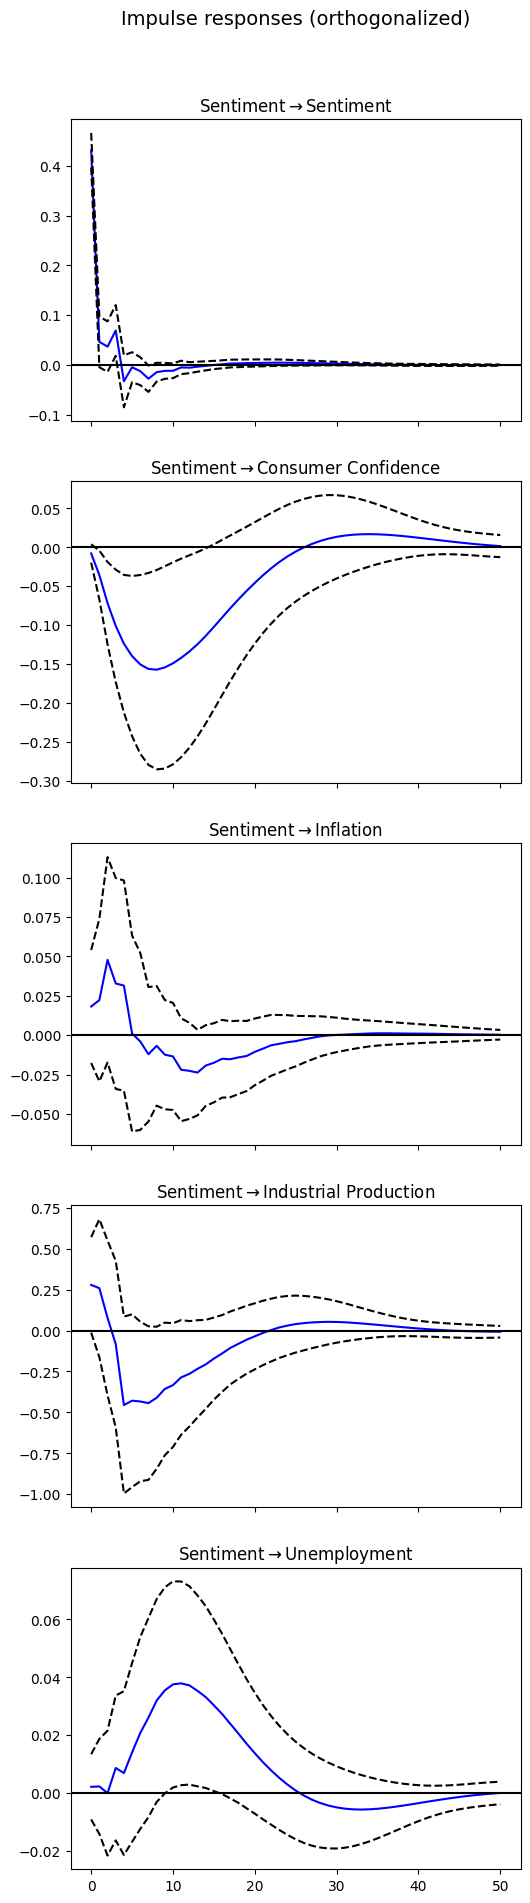

In [29]:
# Get the impulse response functions over a longer period
irf = model_fitted.irf(50)

# Create the plot and get the figure object
fig = irf.plot(impulse='Sentiment', orth=True, signif=0.05)

# Set the figure size
fig.set_size_inches(5, 20)

# Display the plot
plt.show()

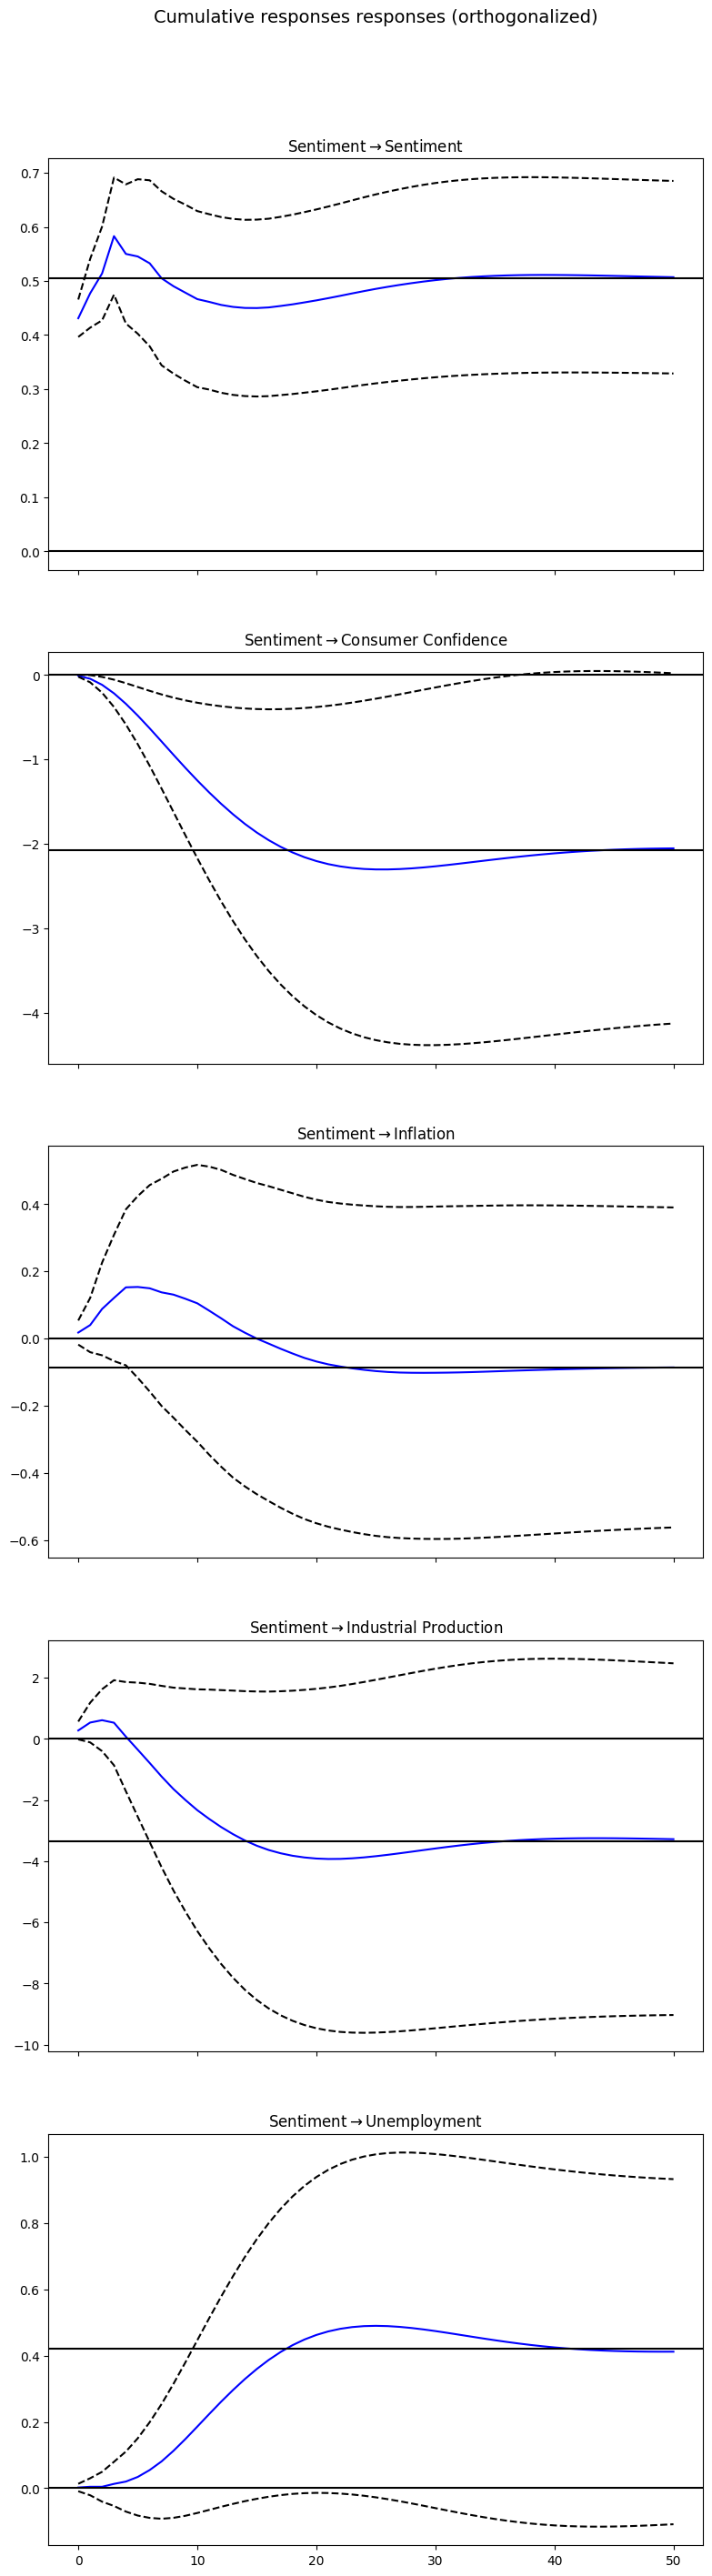

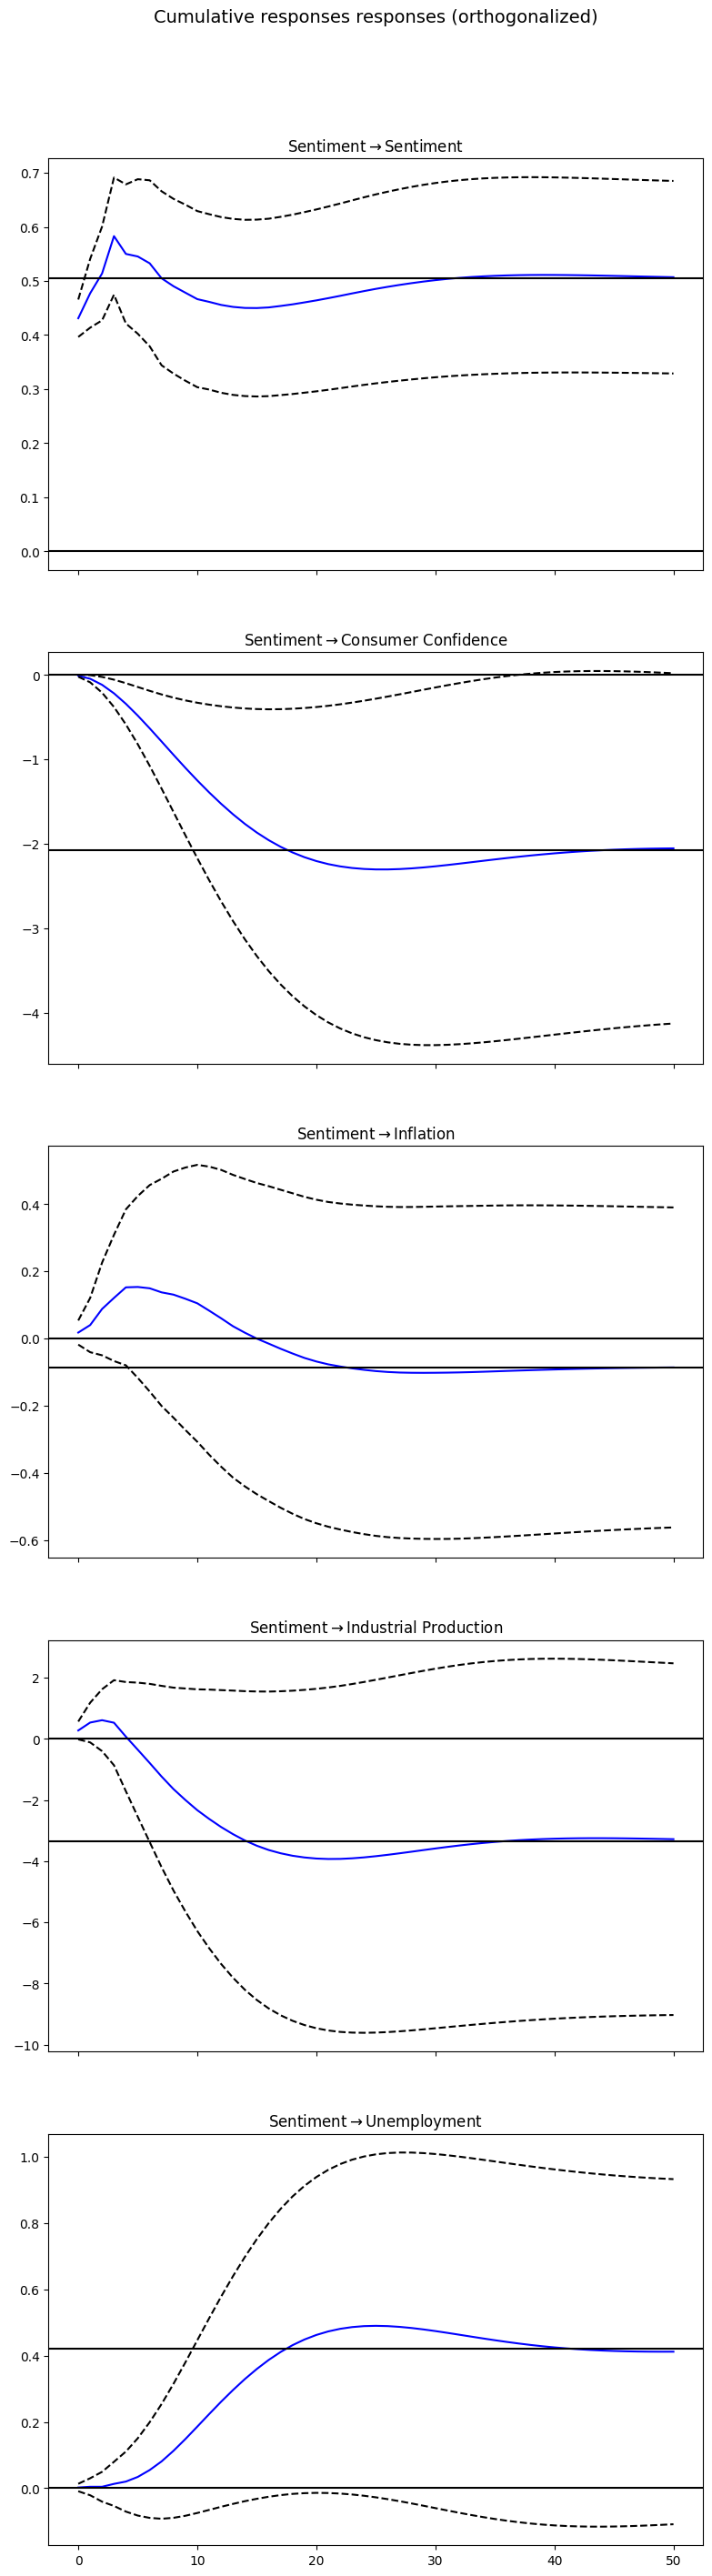

In [30]:
irf.plot_cum_effects(impulse='Sentiment', signif=0.05, orth=True, figsize=(8, 30))

/var/folders/2m/pfct9z0j3p942vw298kpgn4r0000gn/T/ipykernel_76880/1769867956.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


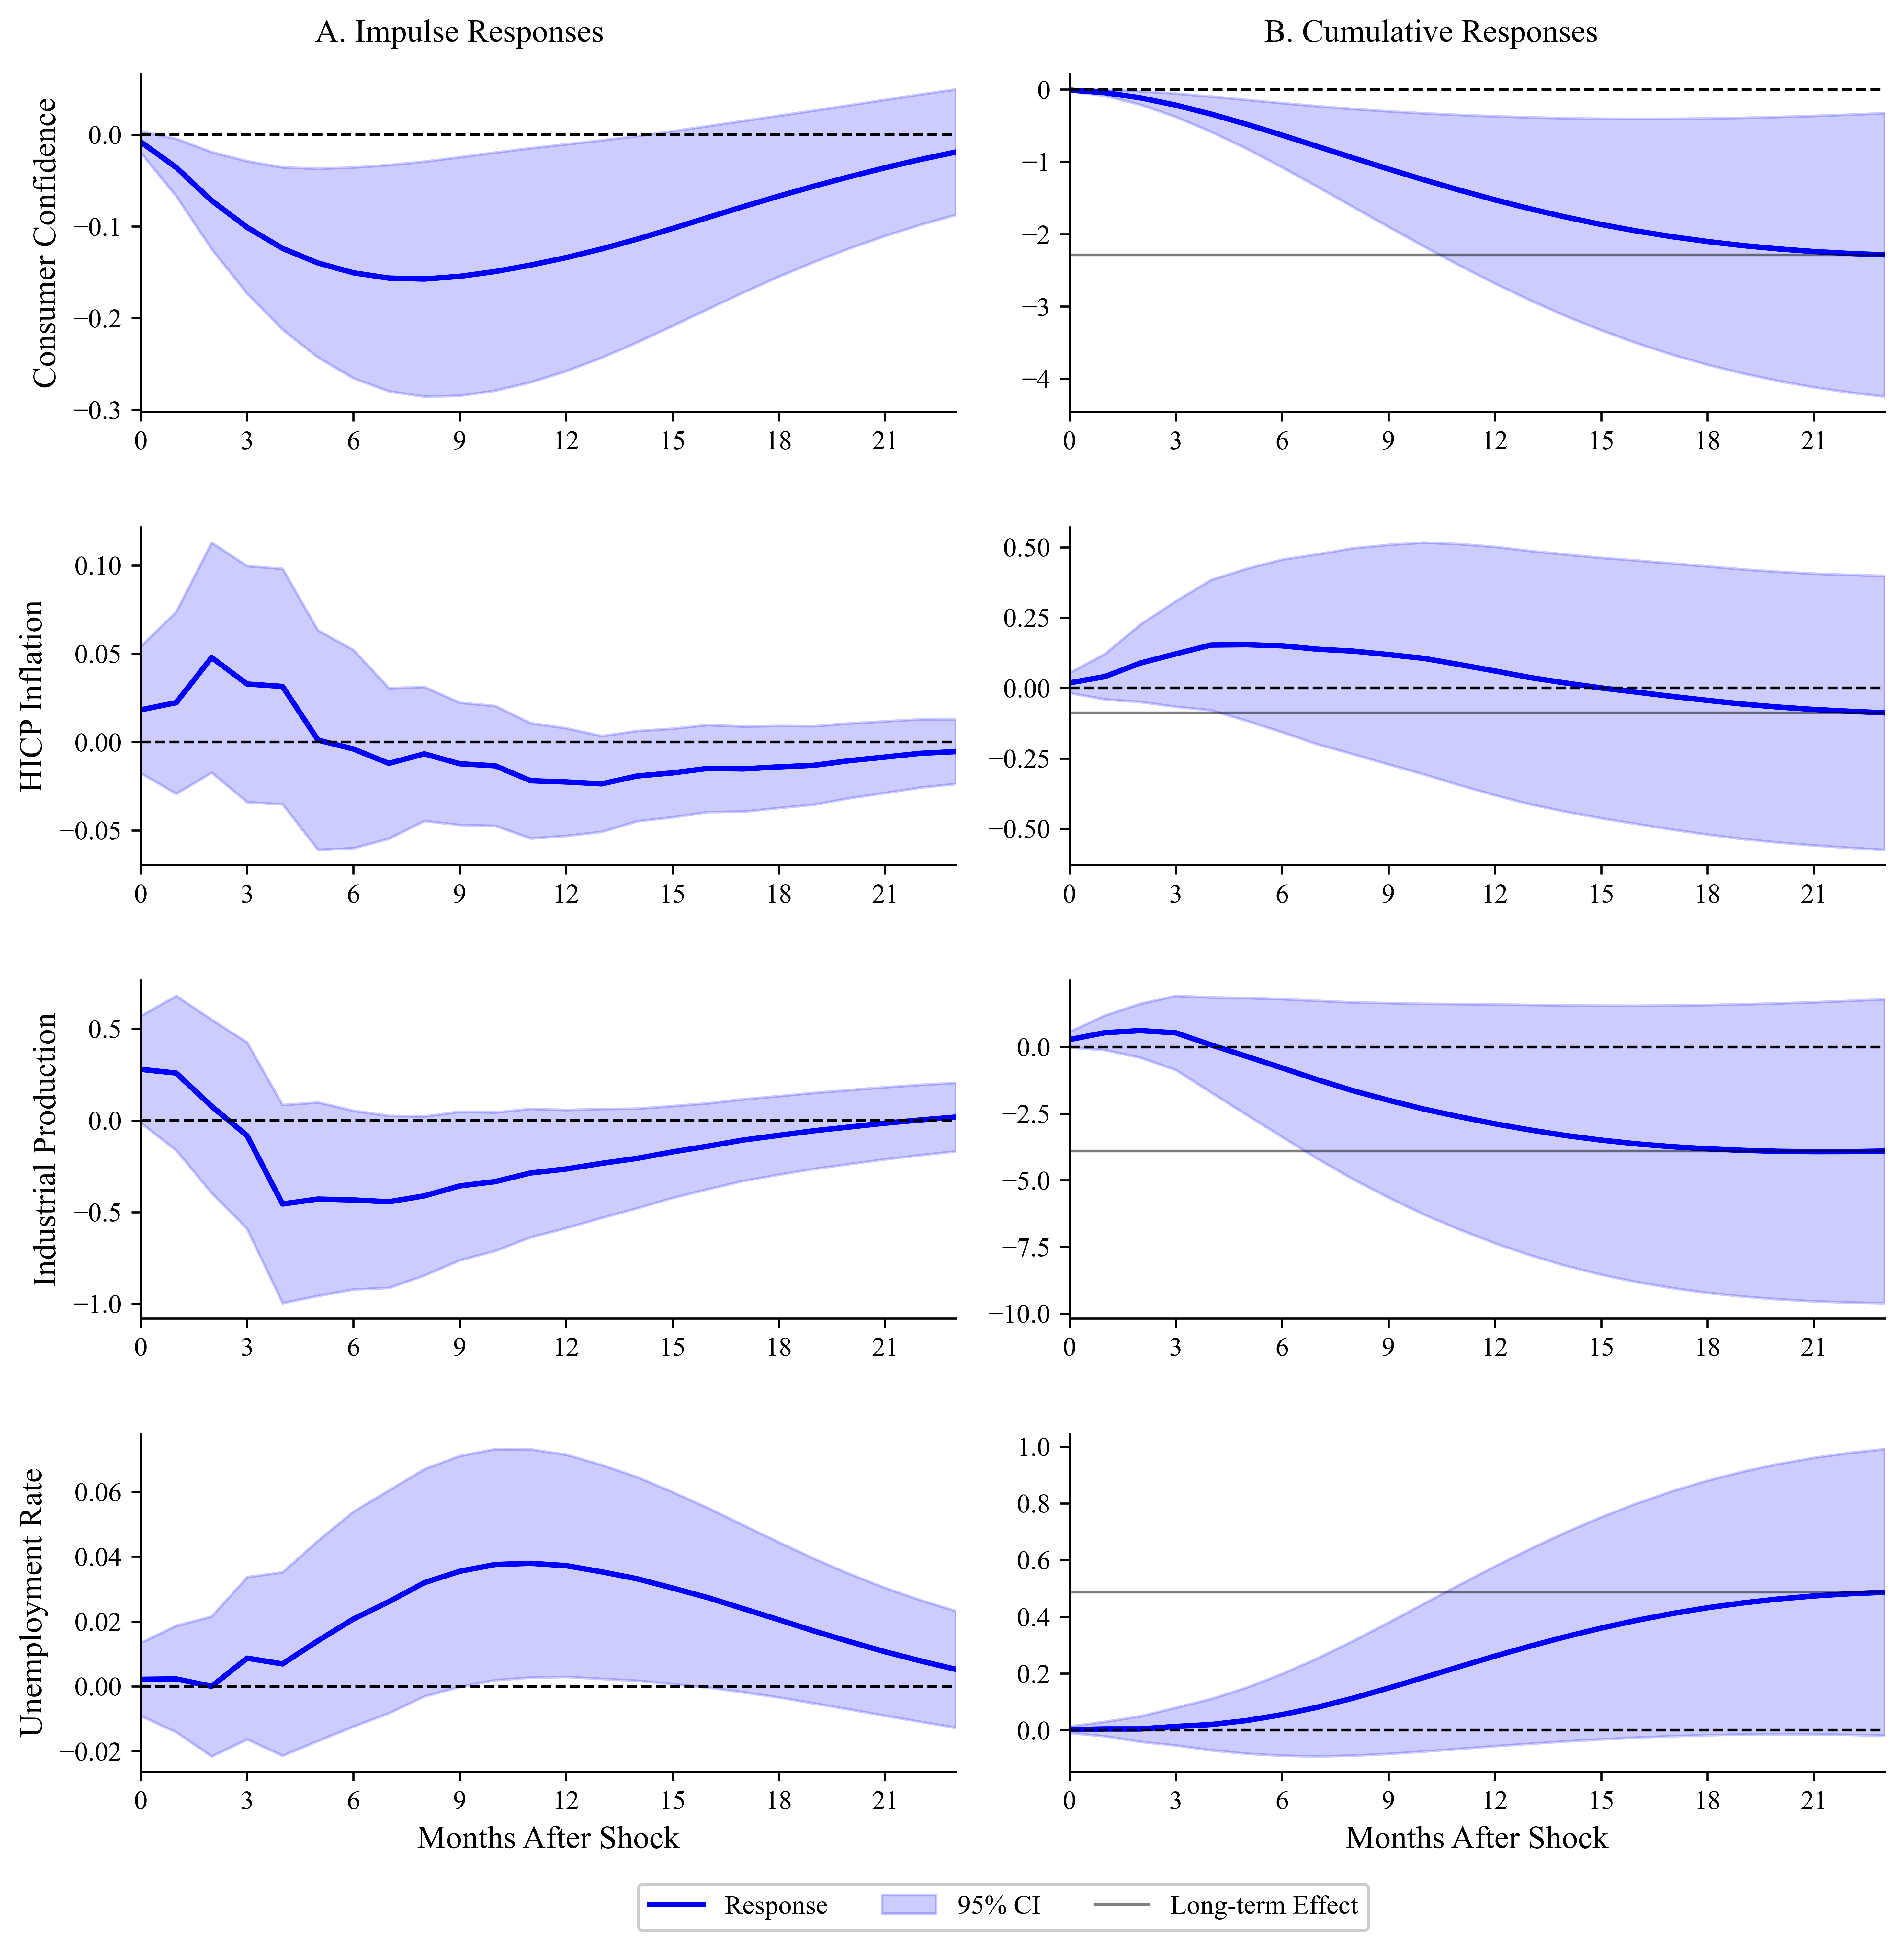

In [ ]:
title_mapping = {
    
    "Inflation": "HICP Inflation",
    "Industrial Production": "Industrial Production",
    "Unemployment": "Unemployment Rate",
    "Sentiment": "Communication Sentiment"
}

plot_order = [ "Consumer Confidence", "Inflation", "Industrial Production", "Unemployment"]

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'lines.linewidth': 1.5,
    'axes.linewidth': 0.8,
    'figure.dpi': 600
})

periods = 24
irf = model_fitted.irf(periods)
irf_cum = model_fitted.irf(periods)  # We'll make this cumulative later

fig = plt.figure(figsize=(10, 12), constrained_layout=False)
gs = gridspec.GridSpec(5, 2, figure=fig)

# Add panel labels
plt.figtext(0.25, 0.95, 'A. Impulse Responses', fontsize=12, ha='center')
plt.figtext(0.75, 0.95, 'B. Cumulative Responses', fontsize=12, ha='center')

# Setup legend 
legend_ax = fig.add_axes([0.43, 0.14, 0.2, 0.02])
legend_ax.plot([], [], 'b-', linewidth=2, label='Response')
legend_ax.fill_between([], [], [], alpha=0.2, color='b', label='95% CI')
legend_ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5, label='Long-term Effect')
legend_ax.axis('off')


legend = legend_ax.legend(loc='center', ncol=4, frameon=True, framealpha=1.0, 
                         facecolor='white', edgecolor='0.8')
legend.set_zorder(100)

# Create IRF plots
for i, name in enumerate(plot_order):
    # Regular IRF plot
    ax1 = fig.add_subplot(gs[i, 0])
    subplot_fig = irf.plot(impulse='Sentiment', response=name, orth=True, signif=0.05)
    
    
    subplot_ax = subplot_fig.get_axes()[0]
    lines = subplot_ax.get_lines()
    
    # Plot the IRF data
    if len(lines) >= 3:
        irf_line = lines[0]
        x_data = irf_line.get_xdata()[:periods]
        y_data = irf_line.get_ydata()[:periods]
        ax1.plot(x_data, y_data, 'b-', linewidth=2)
        
        lower_ci = lines[1]
        lower_y = lower_ci.get_ydata()[:periods]
        
        upper_ci = lines[2]
        upper_y = upper_ci.get_ydata()[:periods]
        
        ax1.fill_between(x_data, lower_y, upper_y, alpha=0.2, color='b')
    
    # Cumulative IRF plot
    ax2 = fig.add_subplot(gs[i, 1])
    subplot_fig_cum = irf_cum.plot_cum_effects(impulse='Sentiment', response=name, orth=True, signif=0.05)
    
    
    subplot_ax_cum = subplot_fig_cum.get_axes()[0]
    lines_cum = subplot_ax_cum.get_lines()
    
    # Plot the cumulative IRF data
    if len(lines_cum) >= 3:
        irf_line_cum = lines_cum[0]
        x_data_cum = irf_line_cum.get_xdata()[:periods]
        y_data_cum = irf_line_cum.get_ydata()[:periods]
        ax2.plot(x_data_cum, y_data_cum, 'b-', linewidth=2)
        
        lower_ci_cum = lines_cum[1]
        lower_y_cum = lower_ci_cum.get_ydata()[:periods]
        
        upper_ci_cum = lines_cum[2]
        upper_y_cum = upper_ci_cum.get_ydata()[:periods]
        
        ax2.fill_between(x_data_cum, lower_y_cum, upper_y_cum, alpha=0.2, color='b')
        
        # Add horizontal line for final cumulative effect
        long_term_effect = y_data_cum[-1]
        ax2.axhline(y=long_term_effect, color='black', linestyle='-', linewidth=1, alpha=0.5)
    
    
    plt.close(subplot_fig)
    plt.close(subplot_fig_cum)
    
    
    for ax in [ax1, ax2]:
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_xlim(0, periods-1)
        
        # Only add x-label for bottom row
        if i == len(plot_order) - 1:
            ax.set_xlabel('Months After Shock')
    
    # Add variable names as titles only on the first row, 
    var_name = title_mapping.get(name, name)
    
    # Add y-axis label on left side only
    ax1.set_ylabel(var_name)


plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save in both vector and raster formats for publication
plt.savefig('combined_sentiment_irf.pdf', dpi=600, bbox_inches='tight')
plt.savefig('combined_sentiment_irf.png', dpi=600, bbox_inches='tight')

plt.show()

In [31]:
from statsmodels.tsa.stattools import grangercausalitytests

test_result = grangercausalitytests(d[['Sentiment', 'Inflation']], maxlag=4)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8412  , p=0.0286  , df_denom=298, df_num=1
ssr based chi2 test:   chi2=4.8900  , p=0.0270  , df=1
likelihood ratio test: chi2=4.8507  , p=0.0276  , df=1
parameter F test:         F=4.8412  , p=0.0286  , df_denom=298, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5467  , p=0.0301  , df_denom=295, df_num=2
ssr based chi2 test:   chi2=7.2137  , p=0.0271  , df=2
likelihood ratio test: chi2=7.1283  , p=0.0283  , df=2
parameter F test:         F=3.5467  , p=0.0301  , df_denom=295, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5284  , p=0.0575  , df_denom=292, df_num=3
ssr based chi2 test:   chi2=7.7669  , p=0.0511  , df=3
likelihood ratio test: chi2=7.6677  , p=0.0534  , df=3
parameter F test:         F=2.5284  , p=0.0575  , df_denom=292, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5738  , p=0.0380  

for lag 4, the p-values for all tests (ssr-based F test, chi-square test, and likelihood ratio test) are below 0.05, suggesting that at this lag length, the first variable does Granger-cause the second at a 5% significance level.